## Projet SVM 


In [89]:
# livrairies 
import kagglehub
import shutil
import os
import pandas as pd
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np

from scipy.stats import zscore
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency


import warnings
warnings.filterwarnings('ignore')


In [90]:
# chemin pour le fichier py avec les foncitons propres
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [91]:
palette = ["#C68E63", "#7F1D1D"] # palette de couleurs 

# I. Analyse exploratoire

In [92]:

#  copier le fichier
target_path = Path("..") / "data"

print("Dataset copié dans le dossier ./data du projet")

# chargement
csv_path = target_path / "smoking.csv"
df = pd.read_csv(csv_path)

print(" dataset chargé, dimensions :", df.shape)


Dataset copié dans le dossier ./data du projet
 dataset chargé, dimensions : (55692, 27)


## 1) Exploration

In [93]:
df.head()       # Aperçu des premières lignes

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


Au total nos avons 55692 lignes et 27 colonnes dans notre jeu de données

###  Vérification des n/a et doublons

In [94]:
df.info() # nous permet de vérifier les types et na de maniere rapide

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

**Corréction noms de variables**

Pour éviter les espaces dans les noms de colonnes, nous ajoutons un "_"

In [95]:
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['ID', 'gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting_blood_sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine_protein',
       'serum_creatinine', 'AST', 'ALT', 'Gtp', 'oral', 'dental_caries',
       'tartar', 'smoking'],
      dtype='object')

In [96]:
#  Valeurs manquantes
df.isna().sum().value_counts()


0    27
Name: count, dtype: int64

In [97]:
df.duplicated().sum()

0

In [98]:
# Suppression des doublons en ignorant la colonne 'ID'
df_no_duplicates = df.drop_duplicates(subset=[col for col in df.columns if col != 'ID'])

# Vérification : afficher le nombre de doublons supprimés
print(f"Nombre de doublons supprimés : {len(df) - len(df_no_duplicates)}")

Nombre de doublons supprimés : 11140


In [99]:
# Remplacement du DataFrame initial par sa version sans doublons 
df = df_no_duplicates

Notre jeu de données ne contient pas de valeurs manquantes de type N/A, comme nous l'avions déjà constaté avec la fonction info()

Concernant les doublons, en ignorant la colonne ID (car elle est unique), nous en avons détecté 11 140, que nous avons donc supprimés

### Types

Nous allons séparer nos variables pour mieux les analyser en numériques, catégorielles, etc., et vérifier que leurs types sont corrects ou s’il faut les corriger

In [100]:
# on utilise la fonction "detect_variable_types" dispo dans le fichier utils.py


def detect_variable_types(df):
    types = {
        "numerical": [],
        "categorical": [],
        "datetime": [],
        "boolean": [],
        "others": []
    }

    for col in df.columns:
        if pd.api.types.is_bool_dtype(df[col]):  # mettre ce test en premier
            types["boolean"].append(col)
        elif pd.api.types.is_numeric_dtype(df[col]):
            types["numerical"].append(col)
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            types["datetime"].append(col)
        elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            types["categorical"].append(col)
        else:
            types["others"].append(col)

    return types


In [101]:
types = detect_variable_types(df)

print(" Variables numériques :", types["numerical"])
print(" Variables catégorielles :", types["categorical"])
print(" Variables date :", types["datetime"])
print(" Variables booléennes :", types["boolean"])


 Variables numériques : ['ID', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting_blood_sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine_protein', 'serum_creatinine', 'AST', 'ALT', 'Gtp', 'dental_caries', 'smoking']
 Variables catégorielles : ['gender', 'oral', 'tartar']
 Variables date : []
 Variables booléennes : []



**Correction des types :**

Certaines variables ont été mal détectées. Nous allons donc corriger ces types et supprimer les variables peu informatives


In [102]:
#  Recatégorisation des variables pour l’analyse et la modélisation

# Supprimer les colonnes non informatives
df = df.drop(columns=["ID", "oral"])

# Recode de 'gender' en variable binaire : 1 = homme, 0 = femme, puis conversion en booléen
df["homme"] = df["gender"].map({"F": 0, "M": 1}).astype(bool)

# Recode des variables 'hearing' : 1 = normal, 2 = problème → 0/1, puis conversion en booléen
df["pb_hearing(left)"] = df["hearing(left)"].map({1: 0, 2: 1}).astype(bool)
df["pb_hearing(right)"] = df["hearing(right)"].map({1: 0, 2: 1}).astype(bool)

# Recode de 'tartar' : Y = 1, N = 0, puis conversion en booléen
df["tartar"] = df["tartar"].map({"Y": 1, "N": 0}).astype(bool)

# Conversion explicite des colonnes booléennes
df["dental_caries"] = df["dental_caries"].astype(bool)
df["smoking"] = df["smoking"].astype(bool)

# Supprimer les anciennes colonnes devenues redondantes
df = df.drop(columns=["gender", "hearing(left)", "hearing(right)"])

# Spécification de 'Urine_protein' comme variable catégorielle ordonnée
df["Urine_protein"] = pd.Categorical(df["Urine_protein"],
                                     categories=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
                                     ordered=True)

# Mise à jour des types pour structurer l’analyse
types = {
    "numerical": df.select_dtypes(include=["int64", "float64"]).columns.tolist(),
    "categorical": df.select_dtypes(include=["object", "category"]).columns.tolist(),
    "boolean": df.select_dtypes(include=["bool"]).columns.tolist()
}


## 2)  Analyse statistique 

###  Variables numériques: 

In [103]:
numerical_cols = types["numerical"] # on définit les colonnes numériques

# Statistiques descriptives
df[numerical_cols].describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting_blood_sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum_creatinine,AST,ALT,Gtp
count,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000
mean,44.210698,164.657030,65.883462,82.077186,1.011730,1.008130,121.529179,76.043320,99.320210,196.996005,126.722257,57.288382,115.037978,14.622235,0.886104,26.213795,27.085002,40.066103
std,12.089196,9.198674,12.823819,9.278384,0.488136,0.488767,13.688876,9.695356,20.845547,36.423237,71.612721,14.795399,40.938284,1.564866,0.226090,19.087304,31.755110,50.723940
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,71.000000,40.000000,46.000000,55.000000,8.000000,4.000000,1.000000,4.900000,0.100000,6.000000,1.000000,1.000000
25%,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,112.000000,70.000000,89.000000,172.000000,74.000000,47.000000,92.000000,13.600000,0.800000,19.000000,15.000000,17.000000
50%,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,120.000000,76.000000,96.000000,195.000000,108.000000,55.000000,113.000000,14.800000,0.900000,23.000000,21.000000,26.000000
75%,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,130.000000,82.000000,104.000000,220.000000,160.000000,66.000000,136.000000,15.700000,1.000000,29.000000,31.000000,44.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,240.000000,146.000000,505.000000,445.000000,999.000000,618.000000,1860.000000,21.100000,11.600000,1311.000000,2914.000000,999.000000


Certaines variables biologiques présentent des valeurs très élevées ou aberrantes. Mais la majorité restent médicalement plausibles dans des cas graves (hépatopathies, diabète, etc.).
Des autres semblent improbables ou suspectes (erreur de saisie, problème d’unité). 


###  Variables catégorielles

In [104]:
for col in types["categorical"]:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())



--- Urine_protein ---
Urine_protein
1.0    42080
2.0     1445
3.0      739
4.0      208
5.0       70
6.0       10
Name: count, dtype: int64


Une forte concentration sur la valeur 1.0 (absence de protéinurie)

Des modalités peu fréquentes à partir de 3.0 : déséquilibre important

### Variables boleans

In [105]:
for col in types["boolean"]:
    print(f"\n {col} ")
    print(df[col].value_counts(normalize=True).map("{:.2%}".format))



 dental_caries 
dental_caries
False    78.65%
True     21.35%
Name: proportion, dtype: object

 tartar 
tartar
True     55.58%
False    44.42%
Name: proportion, dtype: object

 smoking 
smoking
False    63.30%
True     36.70%
Name: proportion, dtype: object

 homme 
homme
True     63.63%
False    36.37%
Name: proportion, dtype: object

 pb_hearing(left) 
pb_hearing(left)
False    97.44%
True      2.56%
Name: proportion, dtype: object

 pb_hearing(right) 
pb_hearing(right)
False    97.40%
True      2.60%
Name: proportion, dtype: object


## 3) Analyse: Univariée & Bivariée



### Numériques:

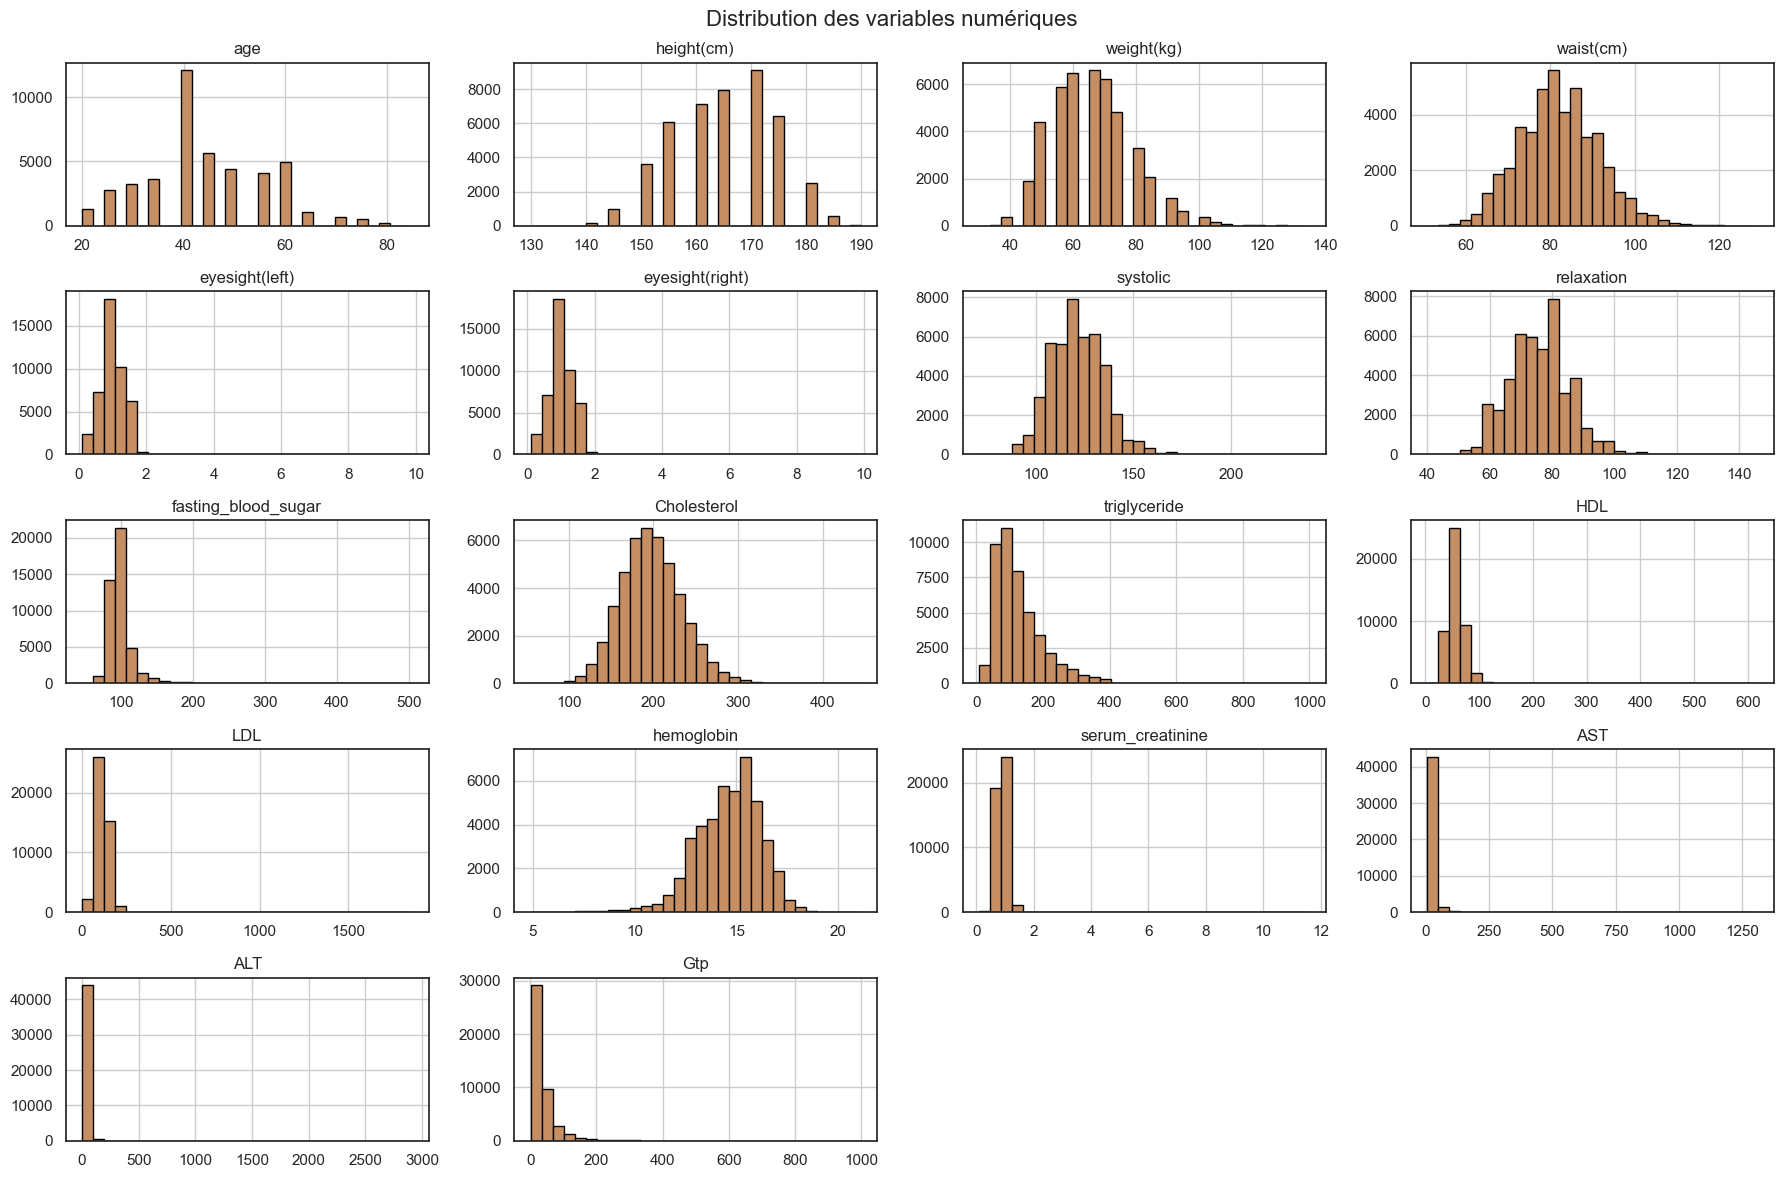

In [106]:
df[numerical_cols].describe().T

# Histogrammes
df[numerical_cols].hist(
    bins=30,
    figsize=(18, 12),
    grid=True,
    color=palette[0],
    edgecolor="black",
)

plt.suptitle("Distribution des variables numériques", fontsize=16)
plt.tight_layout()
plt.show()

###  Catégorielles

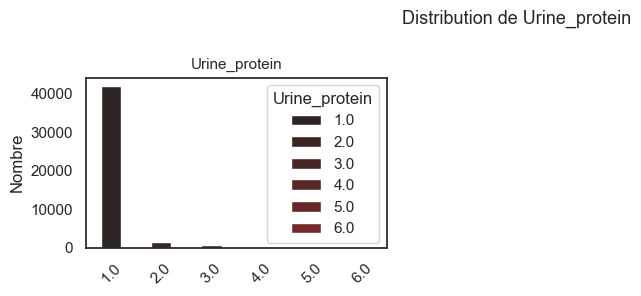

In [107]:

categorical_cols= types["categorical"]

n = len(categorical_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows))

for ax, col in zip(axes.flatten(), categorical_cols):
    sns.countplot(
        x=col,
        data=df,
        hue=col,
        palette='dark:#7F1D1D',
        dodge=False,
        width=0.4,  
        ax=ax
    )
    ax.set_title(f"{col}", fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("Nombre")
    ax.tick_params(axis='x', labelrotation=45)

for ax in axes.flatten()[n:]:
    ax.set_visible(False)

plt.suptitle(f"Distribution de {col}", fontsize=13)
plt.tight_layout()
plt.show()


###  Booléennes

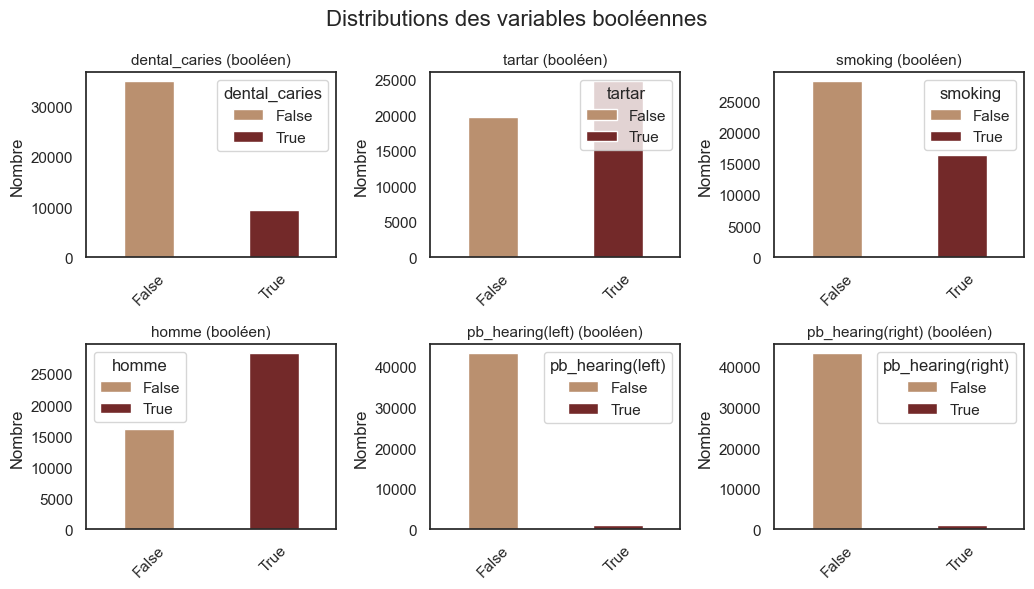

In [108]:
bool_cols = types["boolean"]

n = len(bool_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows))

for ax, col in zip(axes.flatten(), bool_cols):
    sns.countplot(
        x=col,
        data=df,
        hue=col,
        palette=palette,
        dodge=False,
        width=0.4,  
        ax=ax
    )
    ax.set_title(f"{col} (booléen)", fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("Nombre")
    ax.tick_params(axis='x', labelrotation=45)


for ax in axes.flatten()[n:]:
    ax.set_visible(False)

plt.suptitle("Distributions des variables booléennes", fontsize=16)
plt.tight_layout()
plt.show()

### Variable binaire cible :

In [109]:
df['smoking'].value_counts()

smoking
False    28200
True     16352
Name: count, dtype: int64

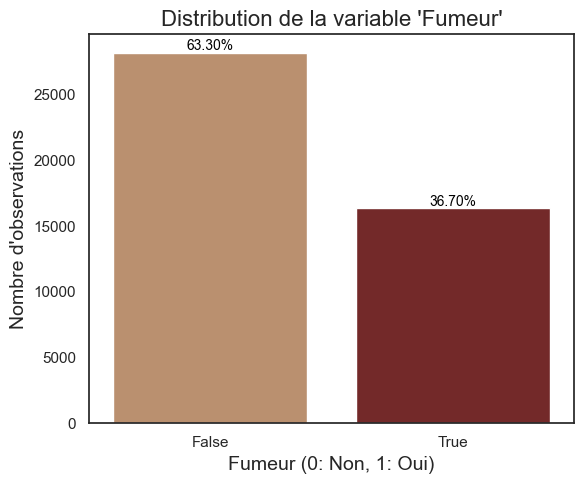

In [110]:
plt.figure(figsize=(6, 5))

# Plotting l'histogramme pour la variable "smoking"
ax = sns.countplot(x='smoking', data=df, palette = palette)

# Ajouter les pourcentages sur les barres
total = len(df)  # Le nombre total d'observations
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100  # Calculer le pourcentage
    ax.annotate(f'{percentage:.2f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Titres et labels
plt.title("Distribution de la variable 'Fumeur'", fontsize=16)
plt.xlabel("Fumeur (0: Non, 1: Oui)", fontsize=14)
plt.ylabel("Nombre d'observations", fontsize=14)

#  graphique
plt.tight_layout()
plt.show()

### Variables numériques vs smoking


In [111]:
df.groupby("smoking")[types["numerical"]].mean().T

smoking,False,True
age,45.693972,41.652703
height(cm),161.899291,169.412916
weight(kg),62.959397,70.926186
waist(cm),80.490858,84.812904
eyesight(left),0.989656,1.049798
eyesight(right),0.984894,1.048202
systolic,120.761809,122.852556
relaxation,75.249149,77.412916
fasting_blood_sugar,97.742376,102.041279
Cholesterol,197.833262,195.552104


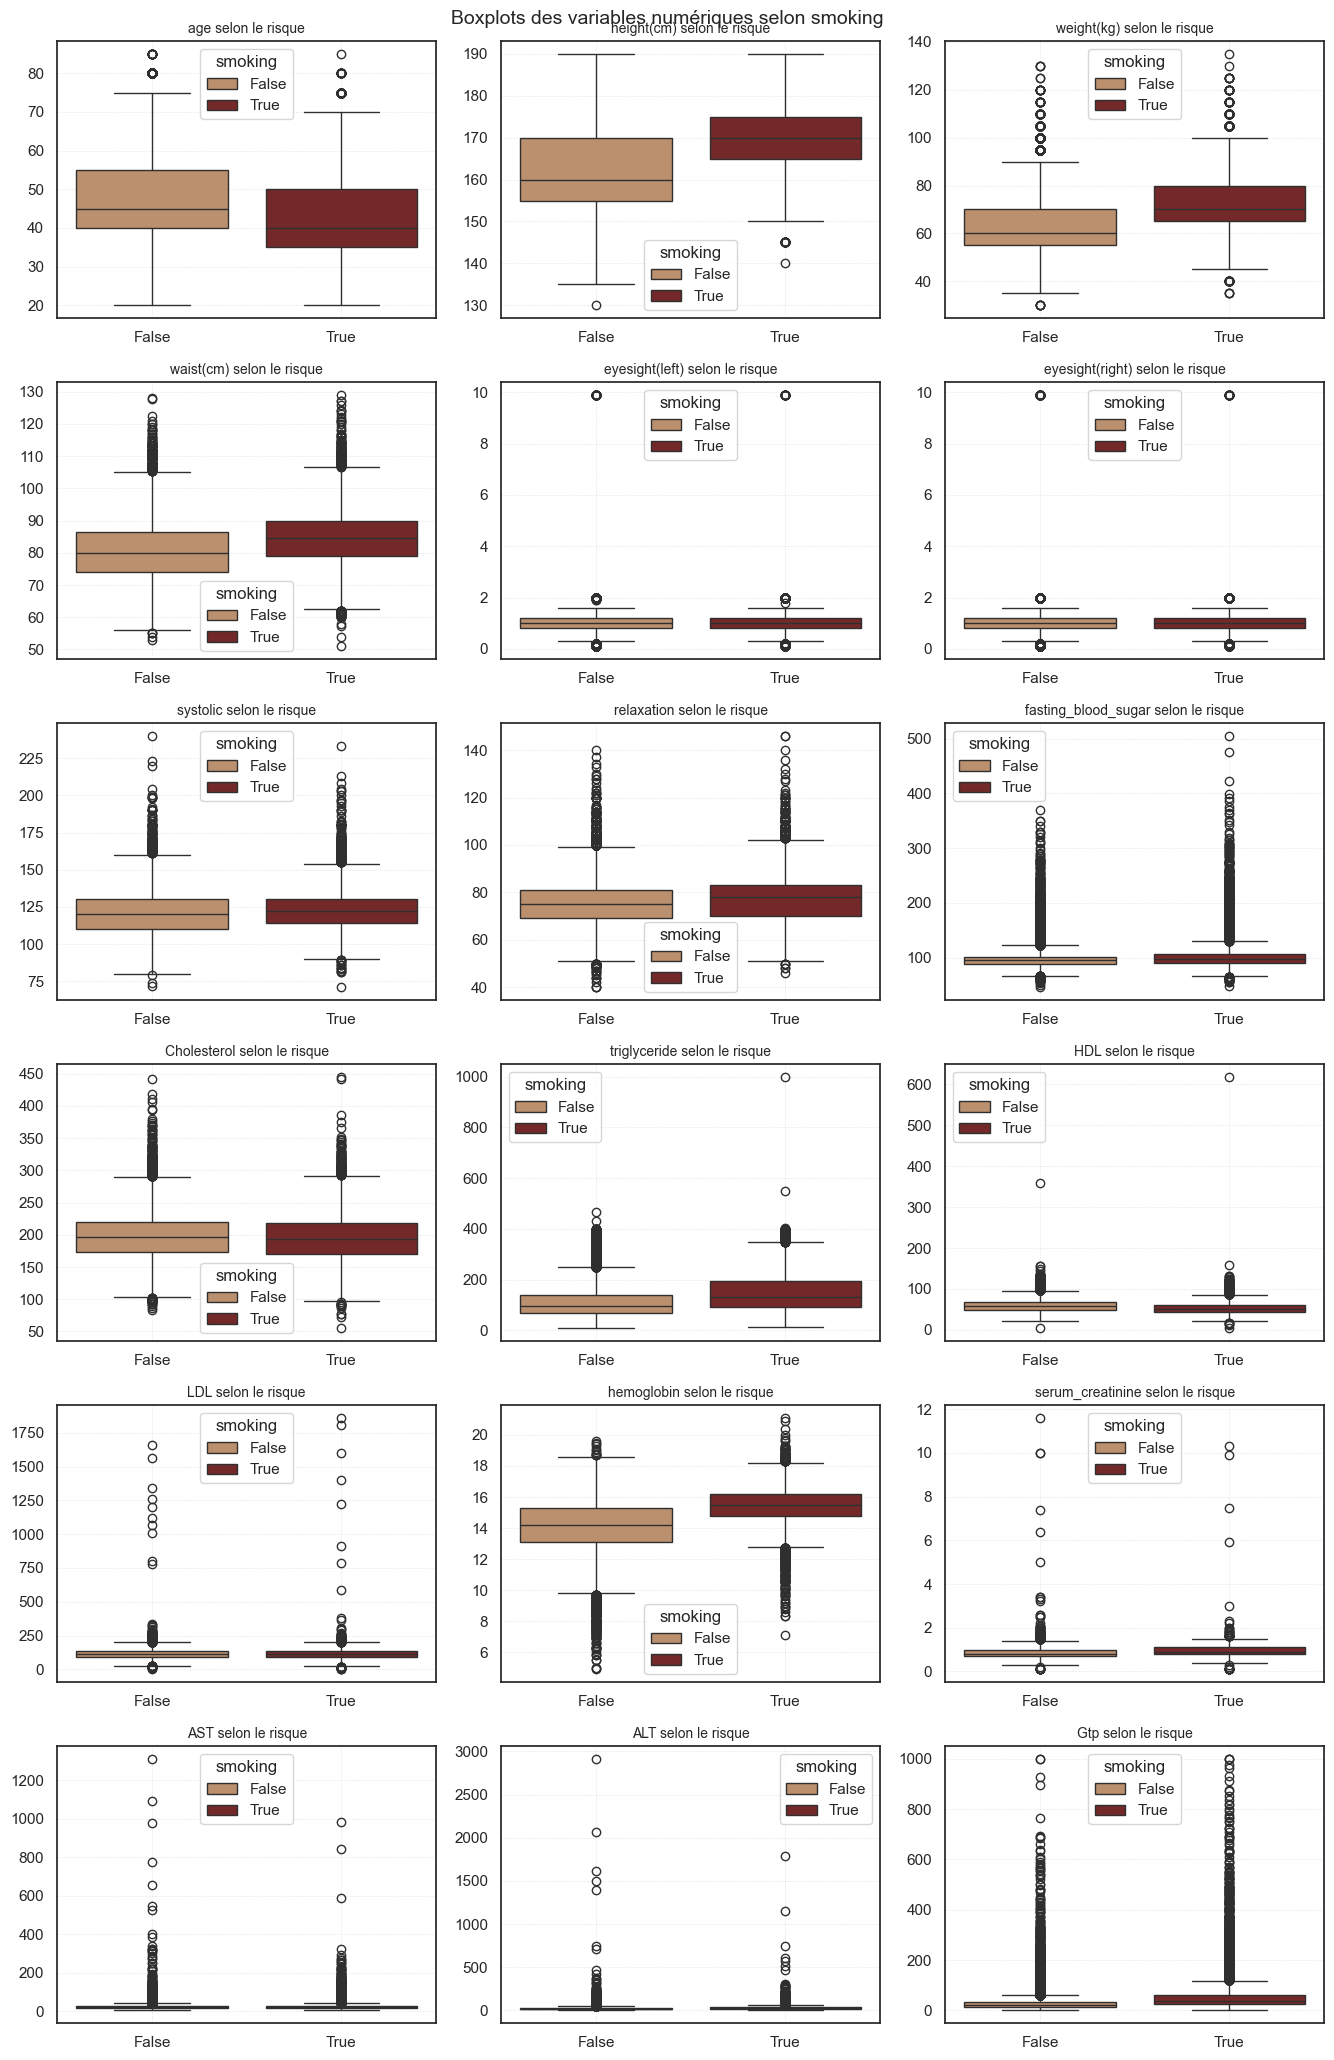

In [112]:
numerical_cols = [
    col for col in types["numerical"]
]

n = len(numerical_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows))

for ax, col in zip(axes.flatten(), numerical_cols):
    sns.boxplot(
        x="smoking",
        y=col,
        data=df,
        hue="smoking",
        palette=palette,
        dodge=False,
        ax=ax
    )
    ax.set_title(f"{col} selon le risque", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.5)
    
for ax in axes.flatten()[n:]:
    ax.set_visible(False)

plt.suptitle("Boxplots des variables numériques selon smoking", fontsize=14)
plt.tight_layout()
plt.show()


### Variables catégorielles / booléennes vs smoking
Objectif : voir si certaines modalités sont plus fréquentes dans le risque

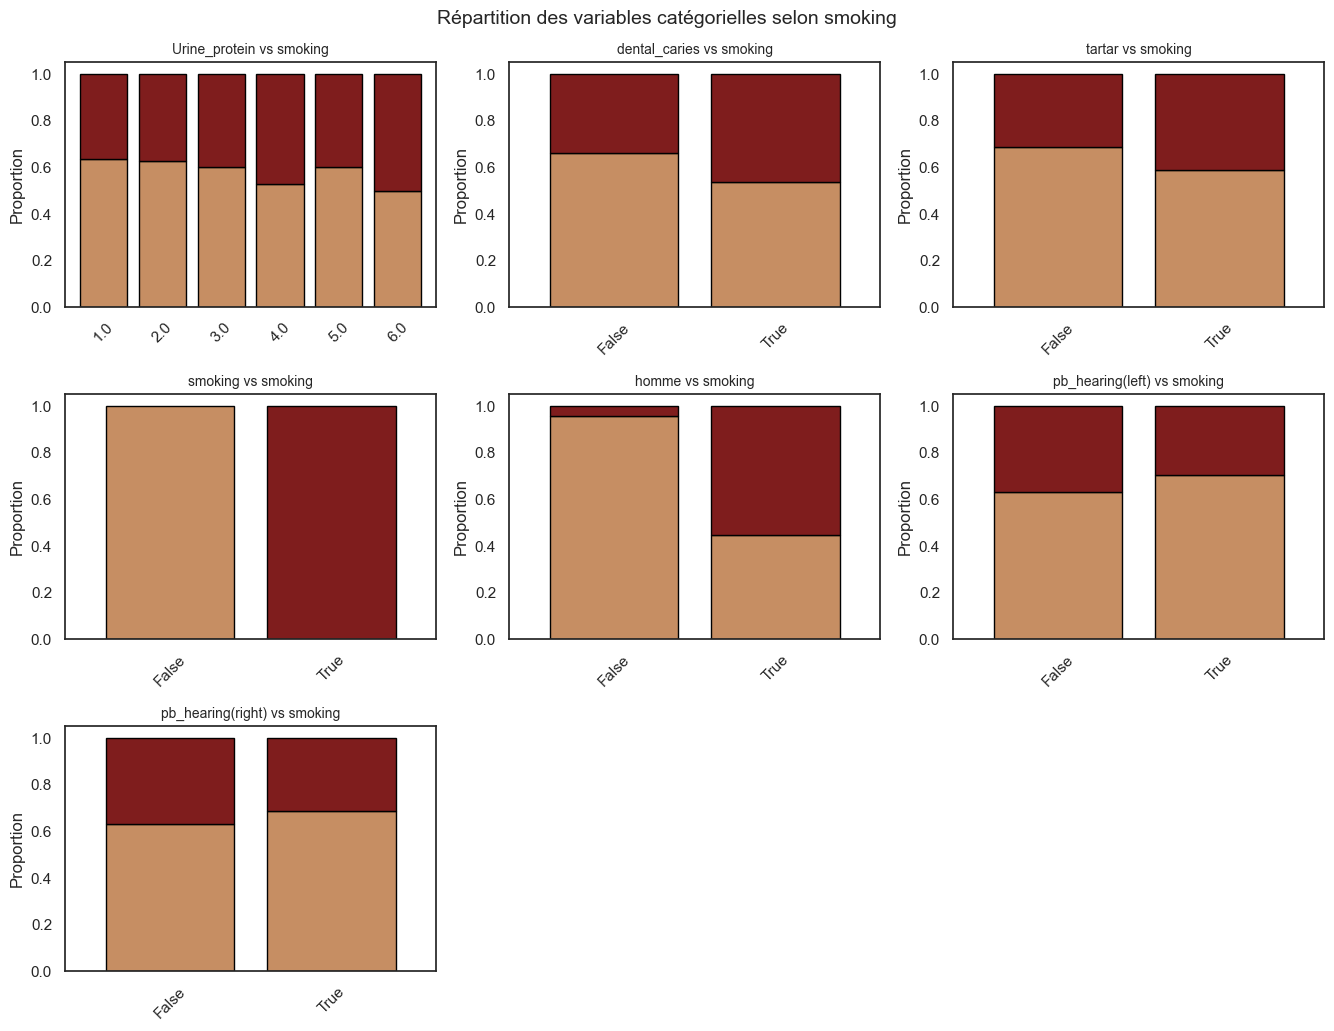

In [113]:
all_cats = types["categorical"] + types["boolean"]

n = len(all_cats)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows))

for ax, col in zip(axes.flatten(), all_cats):
    ct = pd.crosstab(df[col], df["smoking"], normalize='index')
    ct.plot(
        kind='bar',
        stacked=True,
        color=[palette[0], palette[1]],  # ex : ["#C68E63", "#7F1D1D"]
        edgecolor="black",
        ax=ax,
        width=0.8,
        legend=False
    )
    ax.set_title(f"{col} vs smoking", fontsize=10)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis='x', labelrotation=45)

for ax in axes.flatten()[n:]:
    ax.set_visible(False)

plt.suptitle("Répartition des variables catégorielles selon smoking", fontsize=14)
plt.tight_layout()
plt.show()

### Corrélations 

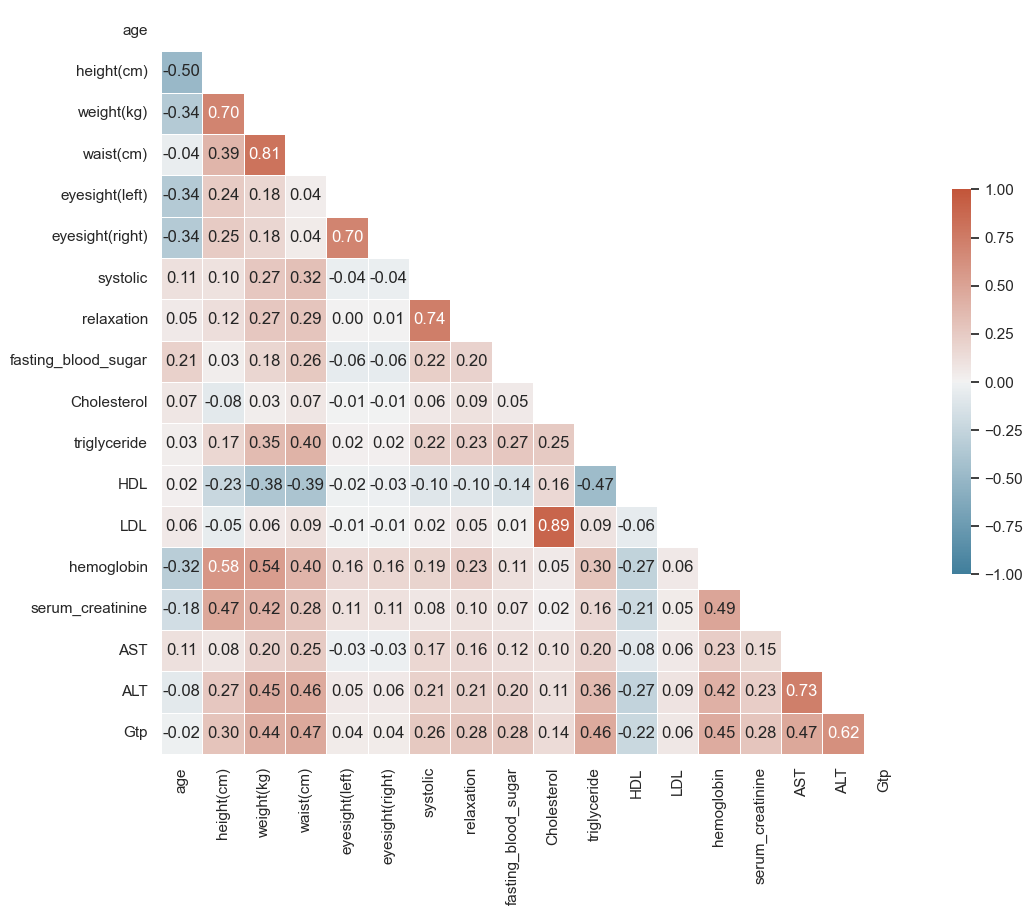

In [114]:
#  matrice de corrélation
sns.set(style="white")
corr = df[types["numerical"]].corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True,
            annot_kws={"size": 12},
            fmt='.2f'
            )
plt.show()


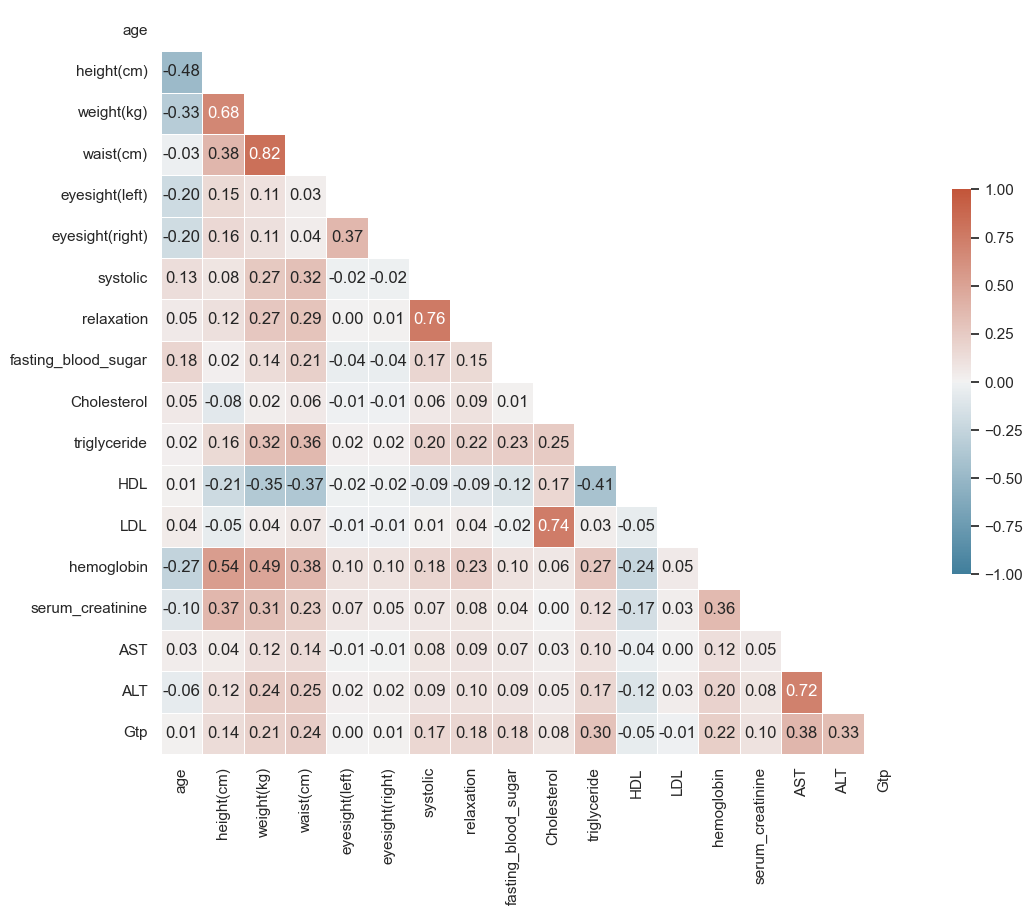

In [115]:
#  matrice de corrélation
sns.set(style="white")
corr = df[types["numerical"]].corr(method="pearson")
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True,
            annot_kws={"size": 12},
            fmt='.2f'
            )
plt.show()


### Corrélations numériques avec riskBinary

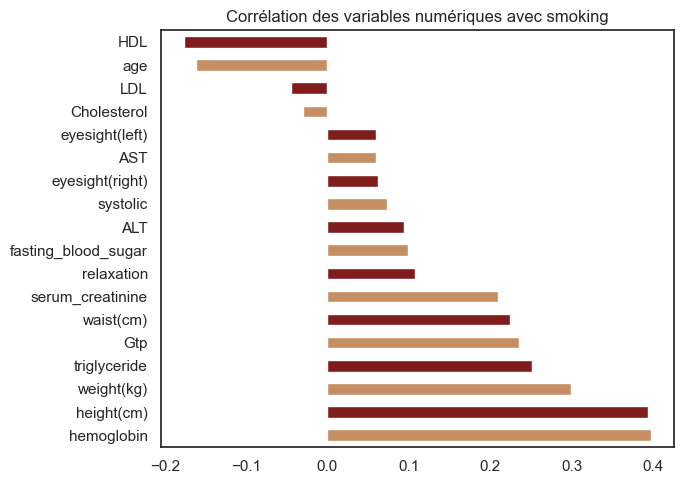

hemoglobin             0.397289
height(cm)             0.393706
weight(kg)             0.299443
triglyceride           0.250896
Gtp                    0.234934
waist(cm)              0.224525
serum_creatinine       0.209255
HDL                    0.175895
age                    0.161127
relaxation             0.107571
fasting_blood_sugar    0.099401
ALT                    0.094384
systolic               0.073618
eyesight(right)        0.062432
AST                    0.059884
eyesight(left)         0.059386
LDL                    0.045016
Cholesterol            0.030187
dtype: float64


In [116]:
numerical_for_corr = [
    col for col in types["numerical"]
]

# Corrélation avec smoking
correlations = df[numerical_for_corr].corrwith(df["smoking"])
correlations.sort_values(ascending=False).plot(
    kind="barh",
    figsize=(7, 5),
    color=palette,
    title="Corrélation des variables numériques avec smoking"
)
plt.tight_layout()
plt.show()

print(correlations.abs().sort_values(ascending=False))


### VIF 
Le VIF (Variance Inflation Factor) nous sert à détecter la multicolinéarité, car  il mesure à quel point une variable est linéairement corrélée aux autres


In [117]:

# Créer une matrice X avec seulement les variables quantitatives
X = df[numerical_cols]

# Ajouter une constante à X pour le calcul du VIF
X = sm.add_constant(X)

# Calculer le VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Afficher le tableau des VIF
print(vif_data.sort_values(by="VIF", ascending=False))

               Variable          VIF
0                 const  1002.895788
3            weight(kg)     6.707472
4             waist(cm)     4.489996
10          Cholesterol     3.532256
13                  LDL     2.985108
2            height(cm)     2.799156
7              systolic     2.511643
8            relaxation     2.462997
17                  ALT     2.207556
16                  AST     2.204299
11         triglyceride     1.921154
12                  HDL     1.826620
14           hemoglobin     1.657475
1                   age     1.644733
18                  Gtp     1.347048
15     serum_creatinine     1.233961
5        eyesight(left)     1.184341
6       eyesight(right)     1.183675
9   fasting_blood_sugar     1.140705


### Lien entre variables quanti et quali (cible) : ANOVA

Avec le test ANOVA nous voulons évaluer si les moyennes d’une variable quantitative est diffèrent significativement entre deux groupes, en l’occurrence les individus fumeurs (smoking == 1) et non-fumeurs (smoking == 0)

In [118]:

# résultats
anova_results = []

for col in numerical_cols:
    group0 = df[df['smoking'] == 0][col]
    group1 = df[df['smoking'] == 1][col]

    f_stat, p_val = f_oneway(group0, group1)
    anova_results.append((col, f_stat, p_val))

# Affichage trié par p-value croissante
anova_df = pd.DataFrame(anova_results, columns=['Variable', 'F-statistic', 'p-value'])
anova_df = anova_df.sort_values(by='p-value')

print(anova_df)

               Variable  F-statistic        p-value
17                  Gtp  2602.532280   0.000000e+00
1            height(cm)  8172.166261   0.000000e+00
2            weight(kg)  4388.075613   0.000000e+00
3             waist(cm)  2365.056884   0.000000e+00
14     serum_creatinine  2040.074838   0.000000e+00
13           hemoglobin  8349.577177   0.000000e+00
10         triglyceride  2992.757094   0.000000e+00
11                  HDL  1422.335613  2.011853e-306
0                   age  1187.429004  7.933960e-257
7            relaxation   521.544340  8.930263e-115
8   fasting_blood_sugar   444.574221   3.308197e-98
16                  ALT   400.432346   1.089470e-88
6              systolic   242.756457   1.373941e-54
5       eyesight(right)   174.324793   9.985528e-40
15                  AST   160.337607   1.104505e-36
4        eyesight(left)   157.671674   4.203317e-36
12                  LDL    90.460191   1.977924e-21
9           Cholesterol    40.634309   1.853465e-10


**Rémarque sur l'interprétation des résultats**

La variable height(cm), présente une forte association avec le statut de fumeur. Toutefois, cette relation doit être interprétée avec prudence, car d’un point de vue biologique, la taille n’a pas de lien causal direct ou plausible avec le tabagisme. Il s’agit donc très probablement d’un effet de confusion, en particulier lié au sexe : les hommes sont en moyenne plus grands que les femmes, et ils sont également plus souvent fumeurs dans la population étudiée. La taille sert alors de proxy implicite pour le genre.

Ce type de biais est important à identifier, car il peut fausser l’interprétation des modèles. 

Nous décidons de ne pas conserver la variable height(cm) pour la modélisation.

In [119]:
df = df.drop(columns=['height(cm)'])

types = {
    "numerical": df.select_dtypes(include=["int64", "float64"]).columns.tolist(),
    "categorical": df.select_dtypes(include=["object", "category"]).columns.tolist(),
    "boolean": df.select_dtypes(include=["bool"]).columns.tolist(),
}
numerical_cols = types["numerical"]

# on vérifie à nouveau le VIF 

# Créer une matrice X avec seulement les variables quantitatives
X = df[numerical_cols]
# Ajouter une constante à X pour le calcul du VIF
X = sm.add_constant(X)

# Calculer le VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

               Variable         VIF
0                 const  303.350359
2            weight(kg)    4.786372
3             waist(cm)    4.071018
9           Cholesterol    3.511996
12                  LDL    2.985082
6              systolic    2.510597
7            relaxation    2.461065
15                  AST    2.204096
16                  ALT    2.203350
10         triglyceride    1.920877
11                  HDL    1.825878
1                   age    1.591540
13           hemoglobin    1.518795
17                  Gtp    1.343189
14     serum_creatinine    1.198473
4        eyesight(left)    1.184125
5       eyesight(right)    1.182543
8   fasting_blood_sugar    1.140658


### Liens quali quali

Avec le test du χ² (chi-deux) on évalue s’il existe une association significative entre chaque variable catégorielle (categorical_cols) et la variable notre variable cible smoking

In [120]:
# lien entre quali et variable cible
categorical_cols = types["categorical"] + types["boolean"]
categorical_cols.remove("smoking")
# stocker les résultats
chi2_results = {}

for col in categorical_cols:
    # Création de la table de contingence
    contingency_table = pd.crosstab(df[col], df["smoking"])
    
    # Test du chi²
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    chi2_results[col] = {
        "p_value": p,
        "chi2_stat": chi2,
        "dof": dof
    }

# Conversion en DataFrame pour tri et lecture
chi2_df = pd.DataFrame(chi2_results).T.sort_values(by="p_value")
print(chi2_df)

                         p_value     chi2_stat  dof
homme               0.000000e+00  11483.103474  1.0
dental_caries      2.799139e-109    493.248296  1.0
tartar             3.950400e-104    469.582402  1.0
pb_hearing(left)    8.088902e-07     24.336563  1.0
pb_hearing(right)   1.561718e-04     14.296297  1.0
Urine_protein       1.198157e-02     14.647108  5.0


In [121]:
# lien quali quali entre elles
chi2_cat_results = {}

# Comparer chaque paire de variables catégorielles
for i, col1 in enumerate(categorical_cols):
    for col2 in categorical_cols[i+1:]:  # Ne comparer que les paires non répétées
        # Création de la table de contingence pour les deux variables
        contingency_table = pd.crosstab(df[col1], df[col2])
        
        # Test du Chi²
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Stockage des résultats dans le dictionnaire
        chi2_cat_results[f"{col1} vs {col2}"] = {
            "p_value": p,
            "chi2_stat": chi2,
            "dof": dof
        }

# Conversion en DataFrame pour tri et lecture
chi2_cat_df = pd.DataFrame(chi2_cat_results).T.sort_values(by="p_value")

# Filtrer les résultats pour n'afficher que ceux avec p-value < 0.05
significant_chi2_cat_df = chi2_cat_df[chi2_cat_df["p_value"] < 0.05]
print(significant_chi2_cat_df)


                                             p_value     chi2_stat  dof
pb_hearing(left) vs pb_hearing(right)   0.000000e+00  11394.509388  1.0
dental_caries vs tartar                2.677021e-292   1335.090453  1.0
dental_caries vs homme                  6.372754e-76    340.002495  1.0
tartar vs homme                         6.722066e-33    142.733488  1.0
tartar vs pb_hearing(left)              8.003806e-13     51.281210  1.0
tartar vs pb_hearing(right)             5.884346e-09     33.872538  1.0
Urine_protein vs homme                  1.283774e-04     25.184133  5.0
dental_caries vs pb_hearing(right)      7.983873e-04     11.244978  1.0
dental_caries vs pb_hearing(left)       5.258357e-03      7.788372  1.0
homme vs pb_hearing(left)               2.674396e-02      4.907265  1.0
Urine_protein vs pb_hearing(right)      3.209753e-02     12.203954  5.0
Urine_protein vs pb_hearing(left)       4.954625e-02     11.094079  5.0


In [122]:
# Vérification qu'il existe une différence de valeur entre hearing left et right justifiant de conserver les 2 variables

# Vérifie combien de fois les valeurs diffèrent entre les deux oreilles
diff_hearing = df[df["pb_hearing(left)"] != df["pb_hearing(right)"]]

# Affiche le nombre de cas où les valeurs diffèrent
print(f"Nombre d'individus avec une différence entre oreille gauche et droite : {len(diff_hearing)}")
diff_hearing[["pb_hearing(left)", "pb_hearing(right)"]].head() # Quelques exemples 

Nombre d'individus avec une différence entre oreille gauche et droite : 1107


,pb_hearing(left),pb_hearing(right)
19,False,True
90,True,False
139,False,True
141,True,False
176,True,False


## 4) Détection des outliers 

In [123]:
Q1 = df[types["numerical"]].quantile(0.25)
Q3 = df[types["numerical"]].quantile(0.75)
IQR = Q3 - Q1

# Les valeurs inférieures à Q1 - 1.5*IQR ou supérieures à Q3 + 1.5*IQR sont des outliers
is_outlier = ((df[types["numerical"]] < (Q1 - 1.5 * IQR)) | 
              (df[types["numerical"]] > (Q3 + 1.5 * IQR)))

outliers_per_col_iqr = is_outlier.sum()

print("Outliers par variable (méthode IQR) :")
print(outliers_per_col_iqr)


Outliers par variable (méthode IQR) :
age                     245
weight(kg)              160
waist(cm)               414
eyesight(left)         1085
eyesight(right)        1084
systolic                555
relaxation              565
fasting_blood_sugar    2657
Cholesterol             487
triglyceride           1802
HDL                     802
LDL                     515
hemoglobin              616
serum_creatinine       2535
AST                    2385
ALT                    2979
Gtp                    3838
dtype: int64


Cela montre que les enzymes hépatiques, la créatinine, la glycémie, les lipides, ainsi que l’acuité visuelle sont les plus touchées par des valeurs extrêmes

In [124]:
path = Path("..") / "data" / "df_clean.csv"
# Enregistrement du DataFrame nettoyé au format CSV
df.to_csv(path, index=False)